In [23]:
# Install missing package
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\darck\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [25]:
#use the path to the dataset files
train_dir = os.path.join(path, 'chest_xray/train')
test_dir = os.path.join(path, 'chest_xray/test')    
val_dir = os.path.join(path, 'chest_xray/val')
# Check if the dataset is downloaded
if not os.path.exists(train_dir):
    print("Dataset not found!")
else:   
    print("Dataset found!")
    # List the files in the directory
    print("Files in train directory:", os.listdir(train_dir)[:10])
    print("Files in test directory:", os.listdir(test_dir)[:10])
    print("Files in val directory:", os.listdir(val_dir)[:10])
# Check the number of images in each directory  

Dataset found!
Files in train directory: ['NORMAL', 'PNEUMONIA']
Files in test directory: ['NORMAL', 'PNEUMONIA']
Files in val directory: ['NORMAL', 'PNEUMONIA']


In [26]:
#size of the dataset
print("Number of training images:", len(os.listdir(train_dir)))
print("Number of test images:", len(os.listdir(test_dir)))  
print("Number of validation images:", len(os.listdir(val_dir)))


# Check the number of images in each class
print("Number of pneumonia images:", len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))
print("Number of normal images:", len(os.listdir(os.path.join(train_dir, 'NORMAL'))))


# Check the number of images in each class in the test set
print("Number of pneumonia images in test set:", len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))))
print("Number of normal images in test set:", len(os.listdir(os.path.join(test_dir, 'NORMAL'))))


# Check the number of images in each class in the validation set
print("Number of pneumonia images in validation set:", len(os.listdir(os.path.join(val_dir, 'PNEUMONIA'))))
print("Number of normal images in validation set:", len(os.listdir(os.path.join(val_dir, 'NORMAL'))))


# Check the size of the images
sample_image_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])
sample_image = cv2.imread(sample_image_path)
print("Sample image shape:", sample_image.shape)




Number of training images: 2
Number of test images: 2
Number of validation images: 2
Number of pneumonia images: 3875
Number of normal images: 1341
Number of pneumonia images in test set: 390
Number of normal images in test set: 234
Number of pneumonia images in validation set: 8
Number of normal images in validation set: 8
Sample image shape: (760, 1152, 3)


In [27]:
# Print the image details
print("Image details:")
print("Height:", sample_image.shape[0])
print("Width:", sample_image.shape[1])
print("Channels:", sample_image.shape[2])
# Print the image size in bytes
print("Size in bytes:", os.path.getsize(sample_image_path))
# Print the image data type
print("Data type:", sample_image.dtype)
# Print the image pixel values
print("Pixel values range:", sample_image.min(), "to", sample_image.max())
# Print the image color space
print("Color space:", "RGB" if sample_image.shape[2] == 3 else "Grayscale")
# Print the image format
print("Format:", "JPEG" if sample_image_path.endswith('.jpg') else "PNG" if sample_image_path.endswith('.png') else "Unknown")


Image details:
Height: 760
Width: 1152
Channels: 3
Size in bytes: 69942
Data type: uint8
Pixel values range: 0 to 255
Color space: RGB
Format: Unknown


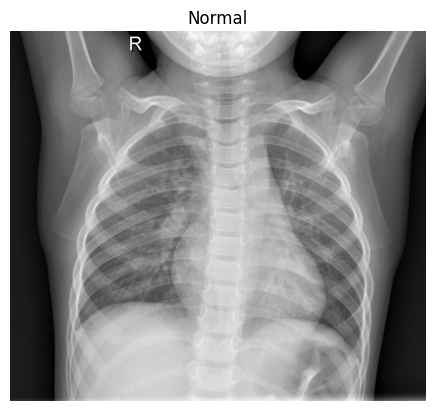

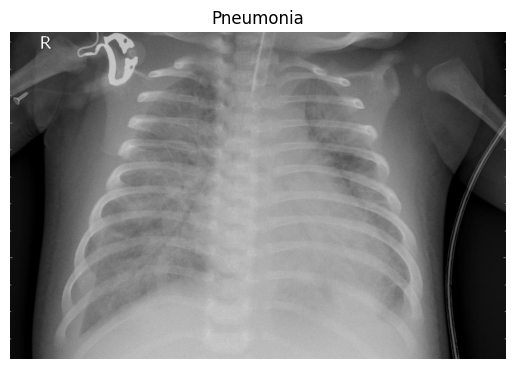

In [28]:
# Display a sample image for normal annd pneumonia
sample_image_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.axis('off')
plt.title("Normal")
plt.show()
sample_image_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.axis('off')
plt.title("Pneumonia")
plt.show()



In [29]:
import torch

def check_gpu():
    if torch.cuda.is_available():
        print(f"GPU est disponible: {torch.cuda.get_device_name(0)}")
    else:
        print("Aucun GPU disponible, utilisation du CPU")

check_gpu()


GPU est disponible: NVIDIA GeForce RTX 3080 Laptop GPU


In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image
import random
import os

# Vérifier si le GPU est disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

Utilisation de: cuda:0


In [31]:
# Chemin vers les données
data_root = r"C:\Users\darck\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"  # Remplacez par le chemin réel de votre dataset
data_dir = data_root  # Utiliser data_root comme chemin racine

# Transformations d'images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
    ]),
    'val':  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Charger les données
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_root, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Créer des DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

# Tailles des ensembles de données
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")
print(f"Nombre d'images - Train: {dataset_sizes['train']}, Validation: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

Classes: ['NORMAL', 'PNEUMONIA']
Nombre d'images - Train: 5216, Validation: 16, Test: 624


In [32]:
from torchvision.transforms import functional as F
import random

# Calculer la différence entre les deux classes
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
augmentation_count = num_pneumonia - num_normal

print(f"Nombre d'images à augmenter pour équilibrer les classes: {augmentation_count}")

# Charger les images de la classe NORMAL
normal_dir = os.path.join(train_dir, 'NORMAL')
normal_images = os.listdir(normal_dir)
normal_images = [os.path.join(normal_dir, img) for img in normal_images]

# Fonction pour appliquer des augmentations
def augment_image(image):
    # Appliquer des transformations aléatoires
    if random.random() > 0.5:
        image = F.hflip(image)  # Inversion horizontale
    if random.random() > 0.5:
        angle = random.uniform(-30, 30)  # Rotation aléatoire
        image = F.rotate(image, angle)
    if random.random() > 0.5:
        scale = random.uniform(0.8, 1.2)  # Zoom aléatoire
        image = F.affine(image, angle=0, translate=(0, 0), scale=scale, shear=0)
    return image

# Générer des images augmentées
augmented_images = []
for _ in range(augmentation_count):
    img_path = random.choice(normal_images)
    image = Image.open(img_path).convert('RGB')
    image = data_transforms['train'](image)  # Appliquer les transformations de base
    image = augment_image(image)  # Appliquer les augmentations
    augmented_images.append(image)

# Convertir en TensorDataset
augmented_images = torch.stack(augmented_images)
augmented_labels = torch.zeros(len(augmented_images))  # Labels pour NORMAL
augmented_dataset = torch.utils.data.TensorDataset(augmented_images, augmented_labels)

# Ajouter au DataLoader d'origine
normal_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)
print(f"Augmentation terminée. Nombre total d'images augmentées: {len(augmented_images)}")


Nombre d'images à augmenter pour équilibrer les classes: 2534
Augmentation terminée. Nombre total d'images augmentées: 2534


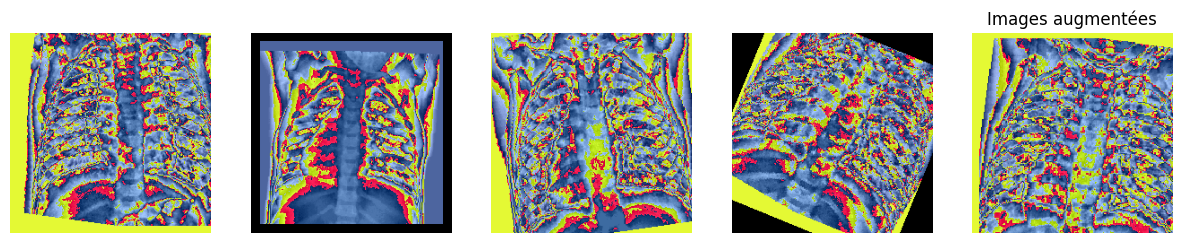

In [33]:
# Afficher quelques images augmentées

# Fonction pour afficher des images
def show_images(images, title=None):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img in zip(axes, images):
        ax.imshow(F.to_pil_image(img))
        ax.axis('off')
    if title:
        plt.title(title)
    plt.show()
# Afficher quelques images augmentées
augmented_images_to_show = random.sample(list(augmented_images), 5)
show_images(augmented_images_to_show, title="Images augmentées")


In [47]:
from sklearn.metrics import confusion_matrix, roc_auc_score  # Import confusion_matrix and roc_auc_score
from sklearn.preprocessing import label_binarize  # Import label_binarize
import seaborn as sns  # Import Seaborn for visualization

# Fonction pour créer le modèle basé sur ResNet34
def create_model():
    # Charger ResNet34 pré-entraîné
    model = models.resnet34(weights='IMAGENET1K_V1')
    
    # Geler les premiers layers pour le transfert learning
    for param in list(model.parameters())[:-8]:  # Ne pas geler les derniers layers
        param.requires_grad = False
    
    # Modifier la dernière couche fully connected pour notre classification binaire
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),  # Augmenter à 512 neurones pour plus de capacité
        nn.BatchNorm1d(512),       # Ajouter une normalisation par batch
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),       # Couche intermédiaire plus large
        nn.BatchNorm1d(256),       # Normalisation supplémentaire
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),       # Normalisation supplémentaire
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)          # 2 classes: Normal et Pneumonie
    )
    
    # Initialisation des poids pour améliorer la convergence
    for m in model.fc.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    return model

# Fonction d'entraînement
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, patience=10, mixup_alpha=0.2):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stop_counter = 0  # Compteur pour le mécanisme d'early stopping
    
    # Pour suivre les métriques
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []  # Ajouter F1 score
    }
    
    # Définir le mixup pour l'augmentation de données
    def mixup_data(x, y, alpha=mixup_alpha, device='cuda'):
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1

        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(device)

        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Chaque epoch a une phase d'entraînement et de validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Mode entraînement
            else:
                model.eval()   # Mode évaluation
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            # Itérer sur les données
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Réinitialiser les gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Appliquer mixup seulement en phase d'entraînement
                    if phase == 'train' and epoch < num_epochs - 2:  # Ne pas utiliser mixup dans les dernières époques
                        inputs_mixed, labels_a, labels_b, lam = mixup_data(inputs, labels, device=device)
                        outputs = model(inputs_mixed)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass + optimize seulement en phase d'entraînement
                    if phase == 'train':
                        loss.backward()
                        # Gradient clipping pour éviter l'explosion des gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()
                
                # Statistiques
                running_loss += loss.item() * inputs.size(0)
                
                # Pour les métriques, utiliser les prédictions non-mixées
                if phase == 'train' and epoch < num_epochs - 2:
                    with torch.no_grad():
                        # Recalculer les prédictions sur les entrées originales pour les métriques
                        outputs_clean = model(inputs)
                        _, preds_clean = torch.max(outputs_clean, 1)
                        all_preds.extend(preds_clean.cpu().numpy())
                else:
                    all_preds.extend(preds.cpu().numpy())
                
                all_labels.extend(labels.cpu().numpy())
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            
            # Enregistrer les métriques
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                history['train_f1'].append(epoch_f1)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                history['val_f1'].append(epoch_f1)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            
            # Copier le modèle si c'est le meilleur (basé sur F1 score maintenant)
            if phase == 'val':
                if epoch_f1 > best_acc:  # Utiliser F1 au lieu de accuracy
                    best_acc = epoch_f1
                    best_model_wts = model.state_dict()
                    early_stop_counter = 0  # Réinitialiser le compteur d'early stopping
                else:
                    early_stop_counter += 1  # Incrémenter le compteur d'early stopping
        
        print()
        
        # Vérifier si le critère d'early stopping est atteint
        if early_stop_counter >= patience:
            print("Early stopping déclenché.")
            break
    
    # Charger les meilleurs poids du modèle
    model.load_state_dict(best_model_wts)
    return model, history

# Fonction pour évaluer sur l'ensemble de test
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # Pour stocker les probabilités
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convertir en arrays numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculer les métriques
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculer l'AUC-ROC (pour problèmes binaires)
    if len(np.unique(all_labels)) == 2:
        roc_auc = roc_auc_score(all_labels, all_probs[:, 1])
    else:
        roc_auc = roc_auc_score(label_binarize(all_labels, classes=np.unique(all_labels)), all_probs, average='weighted', multi_class='ovr')
    
    print("\nRésultats sur l'ensemble de test:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    print("\nMatrice de confusion:")
    print(cm)
    
    # Visualiser la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonie'], 
                yticklabels=['Normal', 'Pneumonie'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.title('Matrice de confusion')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Retourner les métriques pour pouvoir les utiliser ailleurs
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }


# Fonction pour visualiser l'évolution de l'entraînement
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Évolution de la perte')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Évolution de la précision')
    plt.xlabel('Epochs')
    plt.ylabel('Précision')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

Epoch 1/30
----------
train Loss: 1.6195 Acc: 0.8135 F1: 0.8150
val Loss: 0.3312 Acc: 0.8125 F1: 0.8057

Epoch 2/30
----------
train Loss: 0.8169 Acc: 0.8752 F1: 0.8743
val Loss: 0.0974 Acc: 1.0000 F1: 1.0000

Epoch 3/30
----------
train Loss: 0.4276 Acc: 0.9034 F1: 0.9032
val Loss: 0.2801 Acc: 0.8125 F1: 0.8057

Epoch 4/30
----------
train Loss: 0.3828 Acc: 0.9248 F1: 0.9243
val Loss: 0.3508 Acc: 0.8750 F1: 0.8730

Epoch 5/30
----------
train Loss: 0.3257 Acc: 0.9319 F1: 0.9318
val Loss: 0.5025 Acc: 0.7500 F1: 0.7333

Epoch 6/30
----------
train Loss: 0.2886 Acc: 0.9375 F1: 0.9371
val Loss: 0.4695 Acc: 0.7500 F1: 0.7333

Epoch 7/30
----------
train Loss: 0.3112 Acc: 0.9419 F1: 0.9419
val Loss: 0.4038 Acc: 0.8125 F1: 0.8057

Epoch 8/30
----------
train Loss: 0.3119 Acc: 0.9442 F1: 0.9441
val Loss: 0.3378 Acc: 0.8125 F1: 0.8057

Epoch 9/30
----------
train Loss: 0.2928 Acc: 0.9469 F1: 0.9468
val Loss: 0.4424 Acc: 0.8125 F1: 0.8057

Epoch 10/30
----------
train Loss: 0.3418 Acc: 0.9484 F

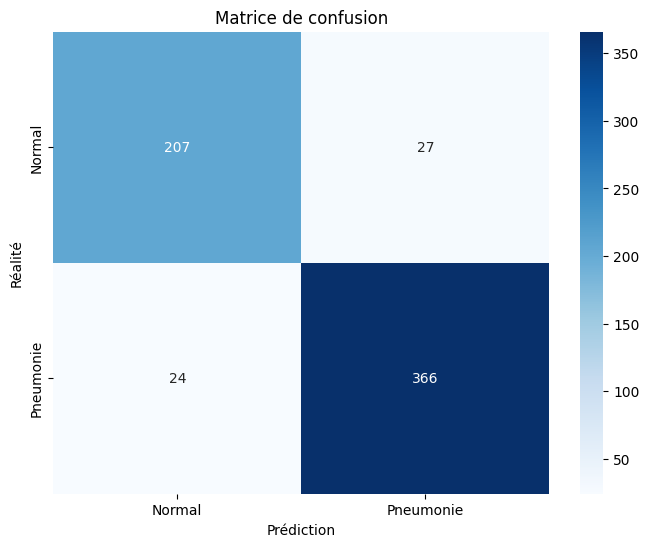

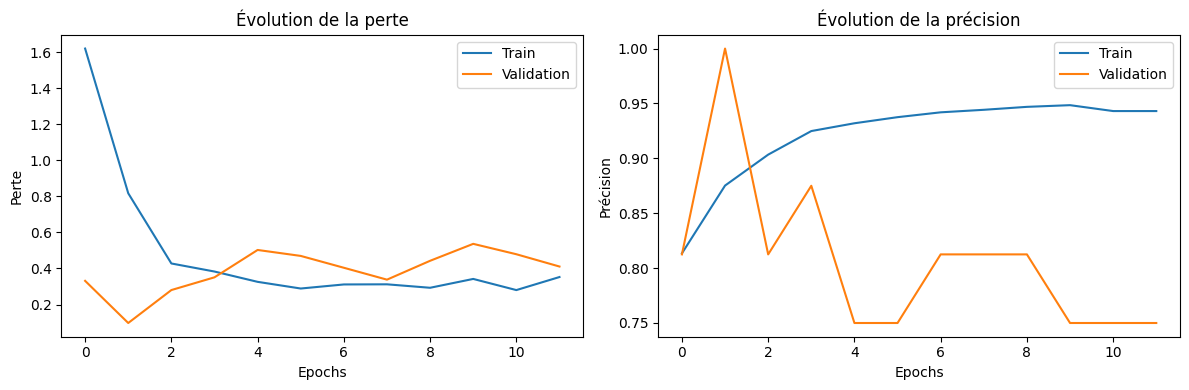

Modèle sauvegardé avec succès.


In [48]:
if __name__ == "__main__":
    # Créer le modèle
    model = create_model()
    model = model.to(device)
    
    # Définir la fonction de perte et l'optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Scheduler pour réduire le learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # Entraîner le modèle
    model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=30)
    
    # Évaluer sur l'ensemble de test
    evaluate_model(model)
    
    # Visualiser l'évolution de l'entraînement
    plot_training_history(history)
    
    # Sauvegarder le modèle
    torch.save(model.state_dict(), '11pneumonia_resnet34.pth')
    print("Modèle sauvegardé avec succès.")


Résultats sur l'ensemble de test:
Accuracy: 0.9183
Precision: 0.9181
Recall: 0.9183
F1 Score: 0.9182
AUC-ROC: 0.9666

Matrice de confusion:
[[207  27]
 [ 24 366]]


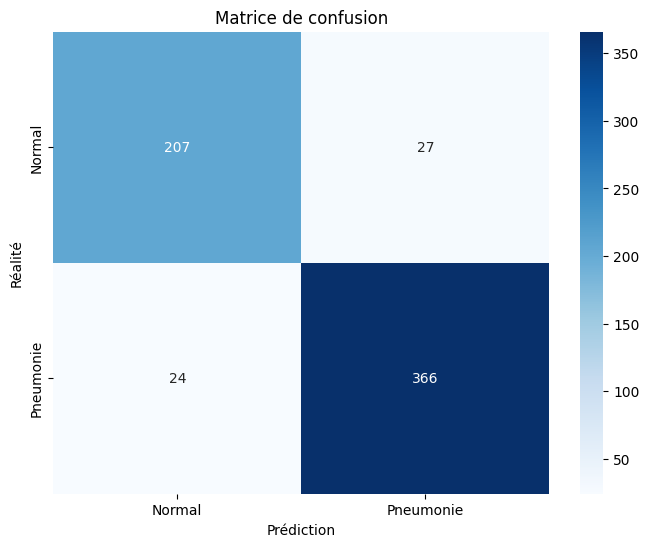

{'accuracy': 0.9182692307692307, 'precision': 0.918100029741251, 'recall': 0.9182692307692307, 'f1': 0.918162155481399, 'roc_auc': 0.9666228358536051, 'confusion_matrix': array([[207,  27],
       [ 24, 366]], dtype=int64)}


In [51]:
# show the metrics
metrics = evaluate_model(model)
print(metrics)

In [49]:
#importer le modèle sauvegardé "densenet_pneumonia_model.pth" et faire une prédiction sur une image
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


# Charger le modèle
# Charger le modèle
model = create_model()  # Assurez-vous que create_model() correspond à l'architecture utilisée pour entraîner le modèle
state_dict = torch.load('11pneumonia_resnet34.pth')

# Charger uniquement les clés correspondantes
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k in model.state_dict() and model.state_dict()[k].shape == v.shape:
        new_state_dict[k] = v
    else:
        print(f"Skipping key: {k} due to shape mismatch or missing key.")

model.load_state_dict(new_state_dict, strict=False)
model.eval()
model.to(device)

#afficher la probabilité de chaque classe


# Fonction pour prédire une image
def predict_image(image_path):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')
    
    # Appliquer les transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension batch
    
    # Prédire
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    
    #afficher la probabilité de chaque classe
    probs = torch.softmax(outputs, dim=1)
    probs = probs.cpu().numpy()
    print(f"Probabilités: {probs}")
    print(f"Prédictions: {preds}")
    

    return preds.item()






Probabilités: [[2.1254702e-05 9.9997878e-01]]
Prédictions: tensor([1], device='cuda:0')
Classe prédite: PNEUMONIA


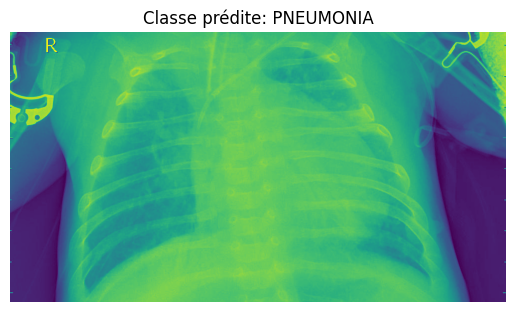

In [50]:
# Chemin de l'image à prédire
image_path = r"C:\Users\darck\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\test\PNEUMONIA\person1_virus_7.jpeg" # Remplacez par le chemin de votre image

# Prédire l'image
predicted_class = predict_image(image_path)
print(f"Classe prédite: {class_names[predicted_class]}")

# Afficher l'image
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Classe prédite: {class_names[predicted_class]}")
plt.axis('off')
plt.show()